In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c mens-march-mania-2022

 83% 38.0M/45.8M [00:00<00:00, 62.6MB/s]
100% 45.8M/45.8M [00:00<00:00, 52.9MB/s]


In [ ]:
!unzip /content/mens-march-mania-2022.zip

Archive:  /content/mens-march-mania-2022.zip
  inflating: MDataFiles_Stage1/Cities.csv  
  inflating: MDataFiles_Stage1/Conferences.csv  
  inflating: MDataFiles_Stage1/MConferenceTourneyGames.csv  
  inflating: MDataFiles_Stage1/MGameCities.csv  
  inflating: MDataFiles_Stage1/MMasseyOrdinals.csv  
  inflating: MDataFiles_Stage1/MNCAATourneyCompactResults.csv  
  inflating: MDataFiles_Stage1/MNCAATourneyDetailedResults.csv  
  inflating: MDataFiles_Stage1/MNCAATourneySeedRoundSlots.csv  
  inflating: MDataFiles_Stage1/MNCAATourneySeeds.csv  
  inflating: MDataFiles_Stage1/MNCAATourneySlots.csv  
  inflating: MDataFiles_Stage1/MRegularSeasonCompactResults.csv  
  inflating: MDataFiles_Stage1/MRegularSeasonDetailedResults.csv  
  inflating: MDataFiles_Stage1/MSampleSubmissionStage1.csv  
  inflating: MDataFiles_Stage1/MSeasons.csv  
  inflating: MDataFiles_Stage1/MSecondaryTourneyCompactResults.csv  
  inflating: MDataFiles_Stage1/MSecondaryTourneyTeams.csv  
  inflating: MDataFiles_Sta

## Part 1: EDA
- In this EDA we will look at the correlation between the statistics placed on the detailed data
- We will look at the data distributions
- According to the details in the Kaggle Competition Site, we can clearly see that almost all of the data is normalized, therefore we can assume that all non-categorical variables are Normally Distributed
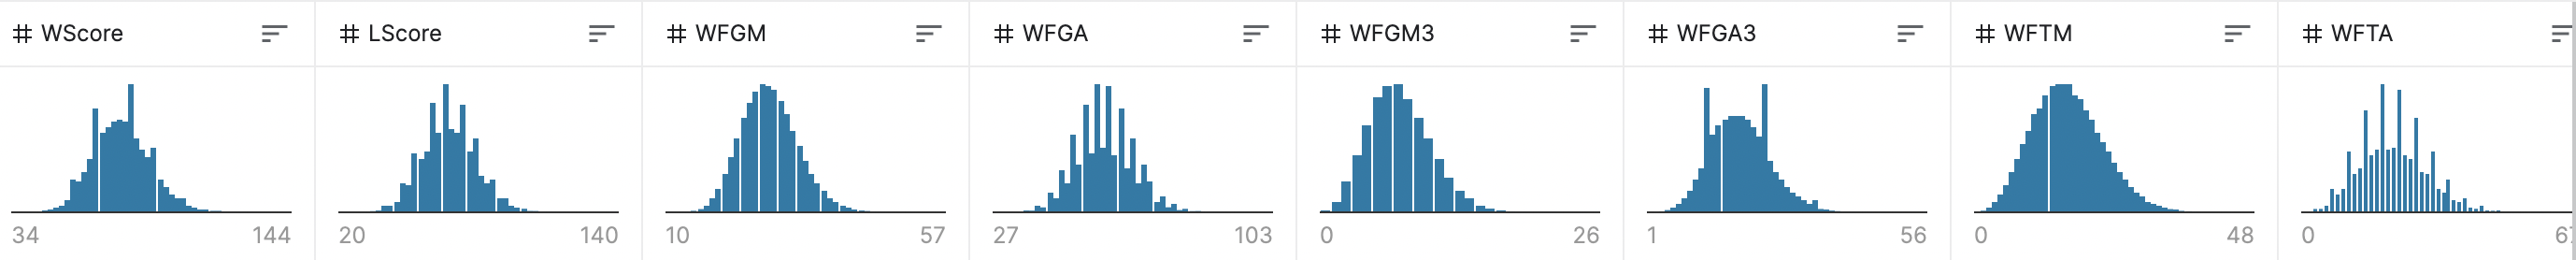

In [ ]:
seed=pd.read_csv('/content/MDataFiles_Stage1/MNCAATourneySeeds.csv')
detailed=pd.read_csv('/content/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
mm_detailed=pd.read_csv('/content/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100423 entries, 0 to 100422
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   100423 non-null  int64 
 1   DayNum   100423 non-null  int64 
 2   WTeamID  100423 non-null  int64 
 3   WScore   100423 non-null  int64 
 4   LTeamID  100423 non-null  int64 
 5   LScore   100423 non-null  int64 
 6   WLoc     100423 non-null  object
 7   NumOT    100423 non-null  int64 
 8   WFGM     100423 non-null  int64 
 9   WFGA     100423 non-null  int64 
 10  WFGM3    100423 non-null  int64 
 11  WFGA3    100423 non-null  int64 
 12  WFTM     100423 non-null  int64 
 13  WFTA     100423 non-null  int64 
 14  WOR      100423 non-null  int64 
 15  WDR      100423 non-null  int64 
 16  WAst     100423 non-null  int64 
 17  WTO      100423 non-null  int64 
 18  WStl     100423 non-null  int64 
 19  WBlk     100423 non-null  int64 
 20  WPF      100423 non-null  int64 
 21  LFGM     1

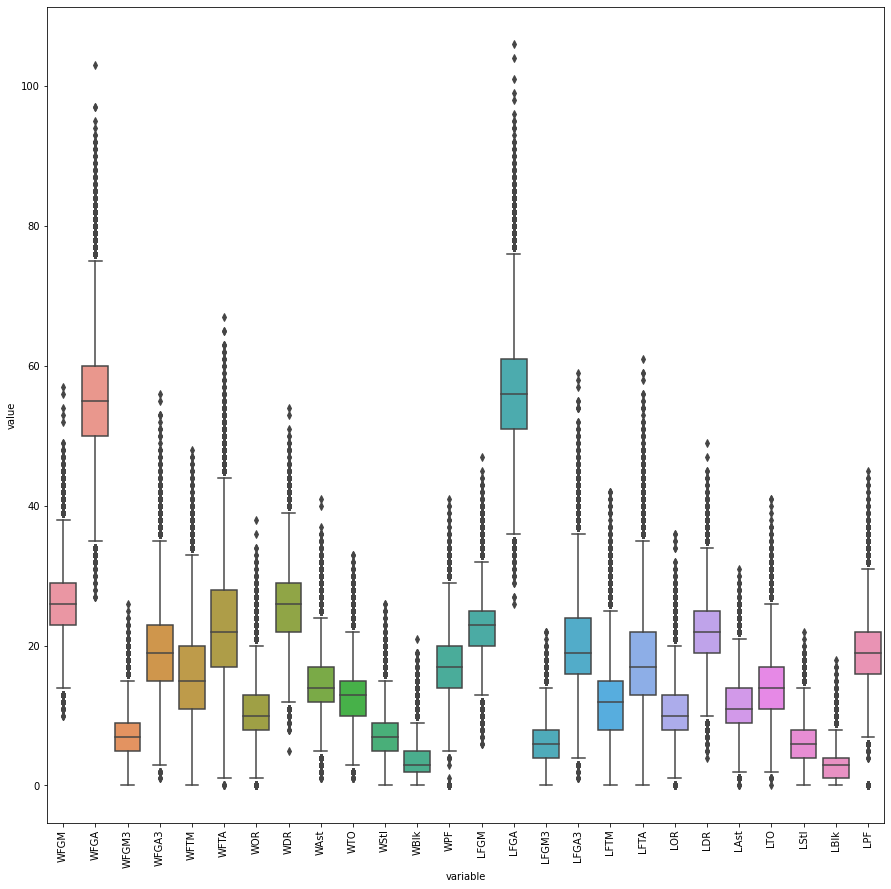

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
fig =sns.boxplot(
    x= "variable",
    y= "value",
    data=pd.melt(detailed.drop(['Season','DayNum','WTeamID','LTeamID','WScore','LScore','WLoc','NumOT'],axis=1))
)
plt.xticks(rotation=90)
plt.show()

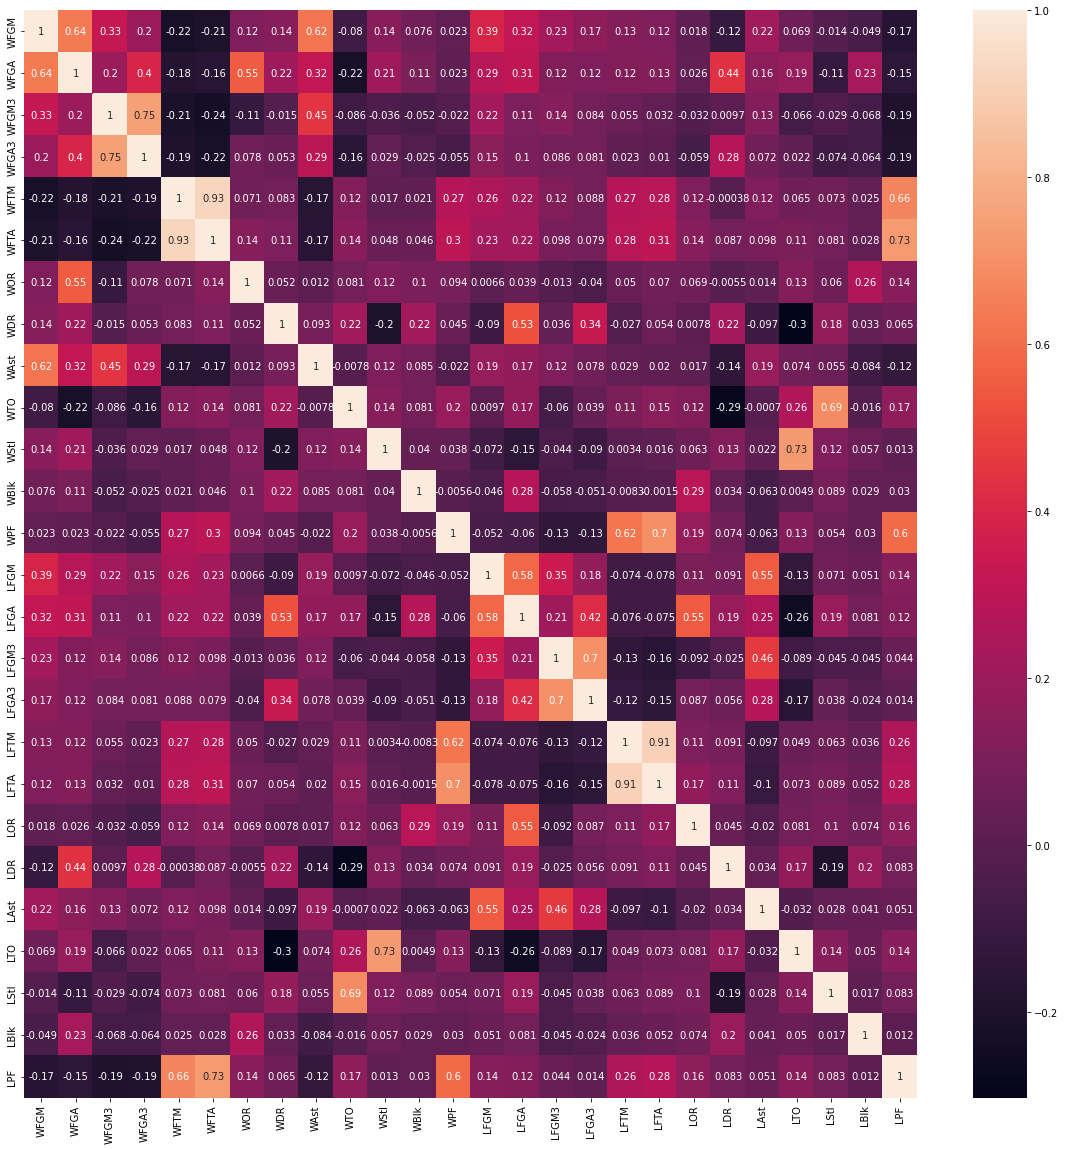

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
fig=sns.heatmap(detailed.drop(['Season','DayNum','WTeamID','LTeamID','WScore','LScore','WLoc','NumOT'],axis=1).corr(),annot=True)
plt.show()

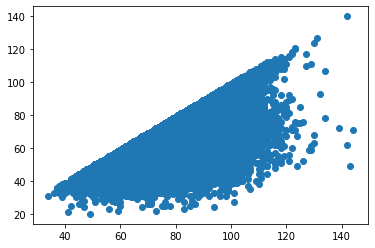

In [ ]:
plt.scatter(x=detailed.WScore,y=detailed.LScore)
plt.show()

Based on our graphs we see things that has been talked about in previous papers of BB Data Science. 
- There is a big correlation in the winning score and the Field Goals Made, it is twice as relevant as the 3 pt attempts
- A team that doesn't provide that much of assist will likely be in the losing column 
- Allowing many field goals will get you in the losing column 

*** 
On the Data distribution side, we can see that all variables have many outliers therefore using the median of this data will be a better way to go. Most of the data is skewed due to a game that goes above the average performance by one or both teams.

## Part 2: Data Preparation
- Since data is skewed we are going to use the median of the data, we will have a wide dataset for the algorithm but the plan is to create 2 different tables: 
  
  - Regular Season Stats
  - Tourney Historic Stats
- Also we will bring the seeds in which they were playing at that tournament and calculate the seed spread. This will help to detect a pattern in upsets and increase the probability of winning given the seed
- Cleaning the data and creating these new datasets will help us get concise, normalized, and clean data.
- The approach for getting everything is to create a unique identifier of the teams in each season, this by concatenating Season and TeamID therefore historic stats won't skew seasons in which the team has a breakdown. 

In [ ]:
win_stats=detailed.groupby(['Season','WTeamID']).median()

In [ ]:
pd.unique(detailed[['WTeamID','LTeamID']].values.ravel('K'))

array([1104, 1272, 1266, 1296, 1400, 1458, 1161, 1186, 1194, 1166, 1202,
       1237, 1323, 1125, 1156, 1183, 1314, 1353, 1390, 1426, 1462, 1196,
       1242, 1422, 1304, 1113, 1116, 1117, 1120, 1122, 1123, 1133, 1139,
       1140, 1141, 1148, 1150, 1151, 1157, 1158, 1160, 1165, 1179, 1187,
       1191, 1200, 1207, 1211, 1217, 1218, 1219, 1232, 1241, 1247, 1250,
       1258, 1261, 1265, 1267, 1277, 1281, 1298, 1301, 1308, 1317, 1320,
       1321, 1328, 1329, 1340, 1343, 1345, 1348, 1349, 1350, 1352, 1365,
       1373, 1375, 1379, 1382, 1384, 1394, 1395, 1397, 1403, 1404, 1412,
       1425, 1427, 1428, 1435, 1436, 1437, 1438, 1451, 1452, 1112, 1124,
       1127, 1131, 1143, 1145, 1153, 1163, 1177, 1178, 1181, 1185, 1198,
       1208, 1209, 1210, 1225, 1226, 1233, 1240, 1257, 1259, 1273, 1274,
       1319, 1335, 1338, 1341, 1344, 1351, 1360, 1371, 1386, 1392, 1409,
       1418, 1420, 1429, 1440, 1442, 1444, 1450, 1453, 1455, 1460, 1461,
       1114, 1138, 1155, 1169, 1173, 1199, 1204, 12

In [ ]:
win_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6883 entries, (2003, 1102) to (2022, 1472)
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DayNum   6883 non-null   float64
 1   WScore   6883 non-null   float64
 2   LTeamID  6883 non-null   float64
 3   LScore   6883 non-null   float64
 4   NumOT    6883 non-null   float64
 5   WFGM     6883 non-null   float64
 6   WFGA     6883 non-null   float64
 7   WFGM3    6883 non-null   float64
 8   WFGA3    6883 non-null   float64
 9   WFTM     6883 non-null   float64
 10  WFTA     6883 non-null   float64
 11  WOR      6883 non-null   float64
 12  WDR      6883 non-null   float64
 13  WAst     6883 non-null   float64
 14  WTO      6883 non-null   float64
 15  WStl     6883 non-null   float64
 16  WBlk     6883 non-null   float64
 17  WPF      6883 non-null   float64
 18  LFGM     6883 non-null   float64
 19  LFGA     6883 non-null   float64
 20  LFGM3    6883 non-null   float64


This matrix called WinStats is to retrieve the data for when a team wins we will create a matrix that keeps only the winning data. Since we want to estimate the probability that a team wins, we will try to compare their winning scores, as well as their win ratio. 

In [ ]:
win_stats= win_stats.reset_index()

In [ ]:
win_stats['ID']=win_stats['Season'].astype(str)+"-"+win_stats['WTeamID'].astype(str)



In [ ]:
win_stats=win_stats.assign(FGRatio= lambda x: win_stats['WFGM']/win_stats['WFGA'],
                 pt3Ratio= lambda x:win_stats['WFGM3']/win_stats['WFGA3'],
                 ORB= lambda x: win_stats['WOR']/(win_stats['WOR']+win_stats['LDR']),
                 Ast_ratio= lambda x: win_stats['WAst']/win_stats['WFGM'],
                 ATO_Ratio= lambda x: win_stats['WAst']/win_stats['WTO'],
                 STO_Ratio= lambda x: win_stats['WStl']/win_stats['WTO'],
                 Blk_eff= lambda x:win_stats['WBlk']/(win_stats['LFGA']+win_stats['LFGA3']),
                 PF_eff= lambda x: (win_stats['WStl']+win_stats['WBlk'])/win_stats['WPF']
                 )
winStats=win_stats[['ID','WScore','LScore','FGRatio','pt3Ratio','ORB','Ast_ratio','ATO_Ratio','STO_Ratio','Blk_eff','PF_eff']].copy()


In [ ]:
winStats=winStats.rename(columns={'WScore':'Pts_4','LScore':'PtsA'})
winStats=winStats.add_suffix('_Reg')
winStats=winStats.rename(columns={'ID_Reg':'ID'})
winStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             6883 non-null   object 
 1   Pts_4_Reg      6883 non-null   float64
 2   PtsA_Reg       6883 non-null   float64
 3   FGRatio_Reg    6883 non-null   float64
 4   pt3Ratio_Reg   6883 non-null   float64
 5   ORB_Reg        6883 non-null   float64
 6   Ast_ratio_Reg  6883 non-null   float64
 7   ATO_Ratio_Reg  6883 non-null   float64
 8   STO_Ratio_Reg  6883 non-null   float64
 9   Blk_eff_Reg    6883 non-null   float64
 10  PF_eff_Reg     6883 non-null   float64
dtypes: float64(10), object(1)
memory usage: 591.6+ KB


In [ ]:
mm_win_stats=mm_detailed.groupby(['Season','WTeamID']).median()
mm_win_stats= mm_win_stats.reset_index()
mm_win_stats['ID']=mm_win_stats['Season'].astype(str)+"-"+mm_win_stats['WTeamID'].astype(str)
mm_win_stats=mm_win_stats.assign(FGRatio= lambda x: mm_win_stats['WFGM']/mm_win_stats['WFGA'],
                 pt3Ratio= lambda x:mm_win_stats['WFGM3']/mm_win_stats['WFGA3'],
                 ORB= lambda x: mm_win_stats['WOR']/(mm_win_stats['WOR']+mm_win_stats['LDR']),
                 Ast_ratio= lambda x: mm_win_stats['WAst']/mm_win_stats['WFGM'],
                 ATO_Ratio= lambda x: mm_win_stats['WAst']/mm_win_stats['WTO'],
                 STO_Ratio= lambda x: mm_win_stats['WStl']/mm_win_stats['WTO'],
                 Blk_eff= lambda x:mm_win_stats['WBlk']/(mm_win_stats['LFGA']+mm_win_stats['LFGA3']),
                 PF_eff= lambda x: (mm_win_stats['WStl']+mm_win_stats['WBlk'])/mm_win_stats['WPF']
                 )
mm_winStats=mm_win_stats[['ID','WScore','LScore','FGRatio','pt3Ratio','ORB','Ast_ratio','ATO_Ratio','STO_Ratio','Blk_eff','PF_eff']].copy()
mm_winStats.head()

,ID,WScore,LScore,FGRatio,pt3Ratio,ORB,Ast_ratio,ATO_Ratio,STO_Ratio,Blk_eff,PF_eff
0,2003-1112,88.0,71.0,0.459459,0.304348,0.341463,0.558824,1.900000,1.000000,0.057471,0.882353
1,2003-1113,84.0,71.0,0.525424,0.428571,0.312500,0.580645,2.000000,0.777778,0.041237,0.578947
2,2003-1120,66.5,62.5,0.433628,0.297297,0.371429,0.448980,0.758621,0.448276,0.070968,0.705882
3,2003-1139,63.0,58.5,0.454545,0.475000,0.293103,0.577778,1.300000,0.450000,0.013889,0.423077
4,2003-1141,79.0,73.0,0.547170,0.428571,0.392857,0.517241,0.833333,0.722222,0.012987,0.736842


In [ ]:
mm_winStats=mm_winStats.rename(columns={'WScore':'Pts_4','LScore':'PtsA'})
mm_winStats=mm_winStats.add_suffix('_MM')
mm_winStats=mm_winStats.rename(columns={'ID_MM':'ID'})
mm_winStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            615 non-null    object 
 1   Pts_4_MM      615 non-null    float64
 2   PtsA_MM       615 non-null    float64
 3   FGRatio_MM    615 non-null    float64
 4   pt3Ratio_MM   615 non-null    float64
 5   ORB_MM        615 non-null    float64
 6   Ast_ratio_MM  615 non-null    float64
 7   ATO_Ratio_MM  615 non-null    float64
 8   STO_Ratio_MM  615 non-null    float64
 9   Blk_eff_MM    615 non-null    float64
 10  PF_eff_MM     615 non-null    float64
dtypes: float64(10), object(1)
memory usage: 53.0+ KB


In [ ]:
winsReg=detailed[['Season','WTeamID']].groupby(['Season','WTeamID']).size()
winsReg=winsReg.reset_index()
winsReg['ID']=winsReg['Season'].astype(str)+'-'+winsReg['WTeamID'].astype(str)
winsReg=winsReg.rename(columns={0:'Wins'})
winsReg=winsReg.drop(columns=['Season','WTeamID'],axis=1)
lossReg=detailed[['Season','LTeamID']].groupby(['Season','LTeamID']).size()
lossReg=lossReg.reset_index()
lossReg['ID']=lossReg['Season'].astype(str)+'-'+lossReg['LTeamID'].astype(str)
lossReg=lossReg.rename(columns={0:'Loss'})
lossReg=lossReg.drop(columns=['Season','LTeamID'],axis=1)
winsReg=winsReg.merge(lossReg,how='left',on='ID')
winsReg['WinRatio']=winsReg['Wins']/winsReg['Loss']
winsReg=winsReg.drop(columns=['Wins','Loss'],axis=1)
winsReg
winStats=winStats.merge(winsReg,how='left',on='ID')

We added the Reg to understand that we have the Regular Season Data. 
With this now calculated we have: 
- Points For
- Points Against
- Field Goal Ratio
- 3 pt Ratio 
- Offensive rebound ratio
- Assist Ratio
- Assist to Turnover Ratio
- Steal to Turnover Ratio
- Blk efficiency
- Personal Foul Efficiency
- Win Ratio in Regular Season

Now with the detailed MM Data we have our Data Transformed, now we need to create the dataset to train the algorithm we are going to use.  

### Part 2.1: Creating the Dataset and adding features

In this part we are going to create the needed dataset to train our algorithm. 

In [ ]:
seed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  2354 non-null   int64 
 1   Seed    2354 non-null   object
 2   TeamID  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [ ]:
seed['ID']=seed['Season'].astype(str)+'-'+seed['TeamID'].astype(str)
seed['SeedN']=seed['Seed'].str[1:3]
seed['SeedN']=seed['SeedN'].astype(int)
seed=seed.drop(columns=['Seed','Season','TeamID'])
mm_winStats=mm_winStats.merge(seed,how='left',on='ID')

In [ ]:
mm_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 34 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   1181 non-null   int64 
 1   DayNum   1181 non-null   int64 
 2   WTeamID  1181 non-null   int64 
 3   WScore   1181 non-null   int64 
 4   LTeamID  1181 non-null   int64 
 5   LScore   1181 non-null   int64 
 6   WLoc     1181 non-null   object
 7   NumOT    1181 non-null   int64 
 8   WFGM     1181 non-null   int64 
 9   WFGA     1181 non-null   int64 
 10  WFGM3    1181 non-null   int64 
 11  WFGA3    1181 non-null   int64 
 12  WFTM     1181 non-null   int64 
 13  WFTA     1181 non-null   int64 
 14  WOR      1181 non-null   int64 
 15  WDR      1181 non-null   int64 
 16  WAst     1181 non-null   int64 
 17  WTO      1181 non-null   int64 
 18  WStl     1181 non-null   int64 
 19  WBlk     1181 non-null   int64 
 20  WPF      1181 non-null   int64 
 21  LFGM     1181 non-null   int64 
 22  

In [ ]:
mm_detailed.head(10)
df=pd.DataFrame(columns=['Season','DayNum','Tm1','Tm2'])
df['Tm1']=mm_detailed[['WTeamID','LTeamID']].min(axis=1)
df['Tm2']=mm_detailed[['WTeamID','LTeamID']].max(axis=1)
df['Season']=mm_detailed.Season
df['DayNum']=mm_detailed.DayNum
df['ID1']=df['Season'].astype(str)+'-'+df['Tm1'].astype(str)
df['ID2']=df['Season'].astype(str)+'-'+df['Tm2'].astype(str)
df=df.merge(winStats,how='left',left_on='ID1',right_on='ID')
df=df.merge(mm_winStats,how='left',left_on='ID1',right_on='ID',suffixes=(None,"_mm_tm1"))
df=df.merge(winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_tm2"))
df=df.merge(mm_winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_mm_tm2"))


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df=df.fillna(0)
df=df.drop(columns=['ID_tm2','ID_mm_tm1','ID_mm_tm2','ID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1181 entries, 0 to 1180
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Season               1181 non-null   int64  
 1   DayNum               1181 non-null   int64  
 2   Tm1                  1181 non-null   int64  
 3   Tm2                  1181 non-null   int64  
 4   ID1                  1181 non-null   object 
 5   ID2                  1181 non-null   object 
 6   Pts_4_Reg            1181 non-null   float64
 7   PtsA_Reg             1181 non-null   float64
 8   FGRatio_Reg          1181 non-null   float64
 9   pt3Ratio_Reg         1181 non-null   float64
 10  ORB_Reg              1181 non-null   float64
 11  Ast_ratio_Reg        1181 non-null   float64
 12  ATO_Ratio_Reg        1181 non-null   float64
 13  STO_Ratio_Reg        1181 non-null   float64
 14  Blk_eff_Reg          1181 non-null   float64
 15  PF_eff_Reg           1181 non-null   f

In [ ]:
df['SeedSpread']=df['SeedN']-df['SeedN_mm_tm2']
df=df.drop(columns=['SeedN','SeedN_mm_tm2'],axis=1)


In [ ]:
df['Target']=np.where(mm_detailed['WTeamID']==df['Tm1'],1,0)
df.head()

,Season,DayNum,Tm1,Tm2,ID1,ID2,Pts_4_Reg,PtsA_Reg,FGRatio_Reg,pt3Ratio_Reg,ORB_Reg,Ast_ratio_Reg,ATO_Ratio_Reg,STO_Ratio_Reg,Blk_eff_Reg,PF_eff_Reg,WinRatio,Pts_4_MM,PtsA_MM,FGRatio_MM,pt3Ratio_MM,ORB_MM,Ast_ratio_MM,ATO_Ratio_MM,STO_Ratio_MM,Blk_eff_MM,PF_eff_MM,Pts_4_Reg_tm2,PtsA_Reg_tm2,FGRatio_Reg_tm2,pt3Ratio_Reg_tm2,ORB_Reg_tm2,Ast_ratio_Reg_tm2,ATO_Ratio_Reg_tm2,STO_Ratio_Reg_tm2,Blk_eff_Reg_tm2,PF_eff_Reg_tm2,WinRatio_tm2,Pts_4_MM_mm_tm2,PtsA_MM_mm_tm2,FGRatio_MM_mm_tm2,pt3Ratio_MM_mm_tm2,ORB_MM_mm_tm2,Ast_ratio_MM_mm_tm2,ATO_Ratio_MM_mm_tm2,STO_Ratio_MM_mm_tm2,Blk_eff_MM_mm_tm2,PF_eff_MM_mm_tm2,SeedSpread,Target
0,2003,134,1411,1421,2003-1411,2003-1421,77.5,68.5,0.481481,0.323529,0.343284,0.576923,0.909091,0.363636,0.022727,0.400000,1.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.0,72.0,0.448276,0.333333,0.382353,0.653846,1.062500,0.562500,0.048193,0.722222,0.812500,92.0,84.0,0.463768,0.37931,0.333333,0.53125,1.416667,0.416667,0.030612,0.363636,-16.0,0
1,2003,136,1112,1436,2003-1112,2003-1436,87.0,69.0,0.454545,0.368421,0.394737,0.633333,1.266667,0.533333,0.045977,0.705882,8.333333,88.0,71.0,0.459459,0.304348,0.341463,0.558824,1.900000,1.000000,0.057471,0.882353,66.0,60.0,0.431034,0.333333,0.387097,0.600000,1.071429,0.500000,0.039474,0.666667,1.900000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,1
2,2003,136,1113,1272,2003-1113,2003-1272,79.0,63.0,0.513274,0.272727,0.412698,0.586207,1.214286,0.428571,0.055172,0.540541,1.636364,84.0,71.0,0.525424,0.428571,0.312500,0.580645,2.000000,0.777778,0.041237,0.578947,73.0,63.0,0.440678,0.400000,0.361111,0.692308,1.285714,0.500000,0.051282,0.611111,3.833333,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.0,1
3,2003,136,1141,1166,2003-1141,2003-1166,85.0,71.0,0.538462,0.444444,0.370370,0.571429,0.888889,0.444444,0.054795,0.600000,3.833333,79.0,73.0,0.547170,0.428571,0.392857,0.517241,0.833333,0.722222,0.012987,0.736842,81.0,63.0,0.526316,0.421053,0.322581,0.600000,1.384615,0.692308,0.073529,0.823529,7.250000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,11.0,1
4,2003,136,1143,1301,2003-1143,2003-1301,77.0,68.0,0.465517,0.352941,0.333333,0.629630,1.214286,0.500000,0.035714,0.588235,2.625000,76.0,74.0,0.421875,0.350000,0.409091,0.629630,1.307692,0.615385,0.025974,0.714286,75.5,63.0,0.490196,0.428571,0.327869,0.640000,1.185185,0.629630,0.034722,0.647059,1.500000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.0,1


In [ ]:
df=df.drop(columns=['ID1','ID2'])

In [ ]:
df=df.fillna(0)

In [ ]:
df=df.replace([np.inf, -np.inf], np.nan)
df=df.fillna(0)
df.head()

,Season,DayNum,Tm1,Tm2,Pts_4_Reg,PtsA_Reg,FGRatio_Reg,pt3Ratio_Reg,ORB_Reg,Ast_ratio_Reg,ATO_Ratio_Reg,STO_Ratio_Reg,Blk_eff_Reg,PF_eff_Reg,WinRatio,Pts_4_MM,PtsA_MM,FGRatio_MM,pt3Ratio_MM,ORB_MM,Ast_ratio_MM,ATO_Ratio_MM,STO_Ratio_MM,Blk_eff_MM,PF_eff_MM,Pts_4_Reg_tm2,PtsA_Reg_tm2,FGRatio_Reg_tm2,pt3Ratio_Reg_tm2,ORB_Reg_tm2,Ast_ratio_Reg_tm2,ATO_Ratio_Reg_tm2,STO_Ratio_Reg_tm2,Blk_eff_Reg_tm2,PF_eff_Reg_tm2,WinRatio_tm2,Pts_4_MM_mm_tm2,PtsA_MM_mm_tm2,FGRatio_MM_mm_tm2,pt3Ratio_MM_mm_tm2,ORB_MM_mm_tm2,Ast_ratio_MM_mm_tm2,ATO_Ratio_MM_mm_tm2,STO_Ratio_MM_mm_tm2,Blk_eff_MM_mm_tm2,PF_eff_MM_mm_tm2,SeedSpread,Target
0,2003,134,1411,1421,77.5,68.5,0.481481,0.323529,0.343284,0.576923,0.909091,0.363636,0.022727,0.400000,1.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.0,72.0,0.448276,0.333333,0.382353,0.653846,1.062500,0.562500,0.048193,0.722222,0.812500,92.0,84.0,0.463768,0.37931,0.333333,0.53125,1.416667,0.416667,0.030612,0.363636,-16.0,0
1,2003,136,1112,1436,87.0,69.0,0.454545,0.368421,0.394737,0.633333,1.266667,0.533333,0.045977,0.705882,8.333333,88.0,71.0,0.459459,0.304348,0.341463,0.558824,1.900000,1.000000,0.057471,0.882353,66.0,60.0,0.431034,0.333333,0.387097,0.600000,1.071429,0.500000,0.039474,0.666667,1.900000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,1
2,2003,136,1113,1272,79.0,63.0,0.513274,0.272727,0.412698,0.586207,1.214286,0.428571,0.055172,0.540541,1.636364,84.0,71.0,0.525424,0.428571,0.312500,0.580645,2.000000,0.777778,0.041237,0.578947,73.0,63.0,0.440678,0.400000,0.361111,0.692308,1.285714,0.500000,0.051282,0.611111,3.833333,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.0,1
3,2003,136,1141,1166,85.0,71.0,0.538462,0.444444,0.370370,0.571429,0.888889,0.444444,0.054795,0.600000,3.833333,79.0,73.0,0.547170,0.428571,0.392857,0.517241,0.833333,0.722222,0.012987,0.736842,81.0,63.0,0.526316,0.421053,0.322581,0.600000,1.384615,0.692308,0.073529,0.823529,7.250000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,11.0,1
4,2003,136,1143,1301,77.0,68.0,0.465517,0.352941,0.333333,0.629630,1.214286,0.500000,0.035714,0.588235,2.625000,76.0,74.0,0.421875,0.350000,0.409091,0.629630,1.307692,0.615385,0.025974,0.714286,75.5,63.0,0.490196,0.428571,0.327869,0.640000,1.185185,0.629630,0.034722,0.647059,1.500000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.0,1


## Part 3: The algorithm
We will try a Logistic Regression being the most simple but powerful since we are trying to get a binary classification and the probabilities. Mainly the win probabilities is the biggest deal. We will do a 90/10 split data because of the limited observations. The Logistic Regression will have a 10 fold CV and a Randomized Search to optimize hyperparameters. We are looking for the following metrics to be fulfilled: 
- Accuracy >82%
- Recall >80% 
- AUC >86%

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
X=df.drop(columns=['Target','Season','DayNum'])
y=df[['Target']]
steps=[('scaler', StandardScaler()),('lr', LogisticRegressionCV(cv=4, n_jobs=2))]
param_dist={
    'lr__Cs':[10,100,1000,10000],
    'lr__solver':['liblinear','lbfgs','sag'],
    'lr__n_jobs':[2],
    'lr__cv':[3,4,5]
}
pipe=Pipeline(steps)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.90,random_state=0)
#search = RandomizedSearchCV(pipe, 
#param_distributions=param_dist, n_iter=20)
#search.fit(X,y)
#search.best_estimator_


In [ ]:
from sklearn.metrics import classification_report
steps=[('scaler', StandardScaler()),('lr', LogisticRegressionCV(cv=4, n_jobs=2,random_state=0))]
pipe=Pipeline(steps)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
y_prob=pipe.predict_proba(X_test)
print(classification_report(y_test,y_pred))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.66      1.00      0.80       544
           1       1.00      0.46      0.63       519

    accuracy                           0.74      1063
   macro avg       0.83      0.73      0.71      1063
weighted avg       0.83      0.74      0.71      1063



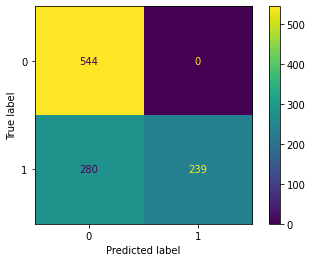

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

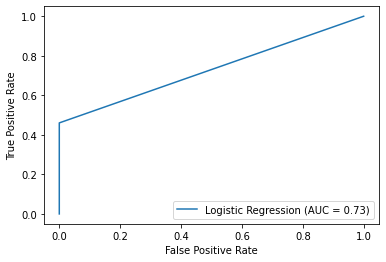

In [ ]:
from sklearn.metrics import roc_curve,auc, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()
plt.show()

Even though we have a poor recall, we are still over the median score in a March Madness Bracket. On a 73% accuracy and correctly predicting the losses gives us a 100% over the last 5 years median. An aproximate hit rate for a bracket is 35%. So we will pack this algorithm and send it to Kaggle. 

In [ ]:
data=pd.read_csv('/content/MDataFiles_Stage1/MSampleSubmissionStage1.csv')
data=data.rename(columns={'ID':'Identifier'})
data=data.drop(columns=['Pred'])
data[['Yr','Tm1','Tm2']]=data['Identifier'].str.split('_', expand=True)
data['ID1']=data['Yr'].astype(str)+'-'+data['Tm1'].astype(str)
data['ID2']=data['Yr'].astype(str)+'-'+data['Tm2'].astype(str)
data=data.merge(winStats,how='left',left_on='ID1',right_on='ID')
data=data.merge(mm_winStats,how='left',left_on='ID1',right_on='ID',suffixes=(None,"_mm_tm1"))
data=data.merge(winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_tm2"))
data=data.merge(mm_winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_mm_tm2"))
data.head()
data=data.drop(columns=['ID_tm2','ID_mm_tm1','ID_mm_tm2','ID'])
data['SeedSpread']=data['SeedN']-data['SeedN_mm_tm2']
data=data.drop(columns=['ID1','ID2'])
data=data.replace([np.inf, -np.inf], np.nan)
data=data.fillna(0)
data.head()

,Identifier,Yr,Tm1,Tm2,Pts_4_Reg,PtsA_Reg,FGRatio_Reg,pt3Ratio_Reg,ORB_Reg,Ast_ratio_Reg,ATO_Ratio_Reg,STO_Ratio_Reg,Blk_eff_Reg,PF_eff_Reg,WinRatio,Pts_4_MM,PtsA_MM,FGRatio_MM,pt3Ratio_MM,ORB_MM,Ast_ratio_MM,ATO_Ratio_MM,STO_Ratio_MM,Blk_eff_MM,PF_eff_MM,SeedN,Pts_4_Reg_tm2,PtsA_Reg_tm2,FGRatio_Reg_tm2,pt3Ratio_Reg_tm2,ORB_Reg_tm2,Ast_ratio_Reg_tm2,ATO_Ratio_Reg_tm2,STO_Ratio_Reg_tm2,Blk_eff_Reg_tm2,PF_eff_Reg_tm2,WinRatio_tm2,Pts_4_MM_mm_tm2,PtsA_MM_mm_tm2,FGRatio_MM_mm_tm2,pt3Ratio_MM_mm_tm2,ORB_MM_mm_tm2,Ast_ratio_MM_mm_tm2,ATO_Ratio_MM_mm_tm2,STO_Ratio_MM_mm_tm2,Blk_eff_MM_mm_tm2,PF_eff_MM_mm_tm2,SeedN_mm_tm2,SeedSpread
0,2016_1112_1114,2016,1112,1114,82.0,64.0,0.465517,0.352941,0.322581,0.592593,1.333333,0.416667,0.0625,0.526316,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,57.0,0.490566,0.444444,0.272727,0.500000,1.444444,0.777778,0.042254,0.588235,6.750000,85.0,83.0,0.389610,0.333333,0.263158,0.30,1.0,1.444444,0.000000,0.590909,12.0,0.0
1,2016_1112_1122,2016,1112,1122,82.0,64.0,0.465517,0.352941,0.322581,0.592593,1.333333,0.416667,0.0625,0.526316,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,74.0,0.486726,0.411765,0.333333,0.545455,1.153846,0.461538,0.028249,0.485714,0.941176,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,2016_1112_1124,2016,1112,1124,82.0,64.0,0.465517,0.352941,0.322581,0.592593,1.333333,0.416667,0.0625,0.526316,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,64.0,0.491228,0.437500,0.406250,0.714286,1.666667,0.583333,0.057143,0.611111,1.909091,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,2016_1112_1138,2016,1112,1138,82.0,64.0,0.465517,0.352941,0.322581,0.592593,1.333333,0.416667,0.0625,0.526316,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,70.0,0.426230,0.375000,0.324324,0.576923,1.250000,0.666667,0.050633,0.571429,1.357143,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,2016_1112_1139,2016,1112,1139,82.0,64.0,0.465517,0.352941,0.322581,0.592593,1.333333,0.416667,0.0625,0.526316,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,71.0,0.500000,0.388889,0.366667,0.551724,1.600000,0.800000,0.037975,0.578947,2.100000,71.0,61.0,0.490196,0.529412,0.266667,0.56,1.0,0.714286,0.027778,0.857143,9.0,0.0


In [ ]:
data['Tm1']=data['Tm1'].astype(int)
data['Tm2']=data['Tm2'].astype(int)
results=data['Identifier']
data.info()
data=data.drop(columns=['Identifier','SeedN','SeedN_mm_tm2','Yr'])

r=pipe.predict_proba(data)
print(r)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11390 entries, 0 to 11389
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Identifier           11390 non-null  object 
 1   Yr                   11390 non-null  object 
 2   Tm1                  11390 non-null  int64  
 3   Tm2                  11390 non-null  int64  
 4   Pts_4_Reg            11390 non-null  float64
 5   PtsA_Reg             11390 non-null  float64
 6   FGRatio_Reg          11390 non-null  float64
 7   pt3Ratio_Reg         11390 non-null  float64
 8   ORB_Reg              11390 non-null  float64
 9   Ast_ratio_Reg        11390 non-null  float64
 10  ATO_Ratio_Reg        11390 non-null  float64
 11  STO_Ratio_Reg        11390 non-null  float64
 12  Blk_eff_Reg          11390 non-null  float64
 13  PF_eff_Reg           11390 non-null  float64
 14  WinRatio             11390 non-null  float64
 15  Pts_4_MM             11390 non-null 

In [ ]:
def Extract(lst):
    return [item[0] for item in lst]
p=Extract(r)
t=pd.Series(p)
results=pd.concat([results,t],axis=1)
results=results.rename(columns={'Identifier':'ID',0:'Pred'})
results=results.set_index('ID')
results = results.loc[:,~results.columns.duplicated()]
results

,Pred
ID,
2016_1112_1114,0.641467
2016_1112_1122,0.554475
2016_1112_1124,0.557005
2016_1112_1138,0.548501
2016_1112_1139,0.659635
...,...
2021_1452_1457,0.454139
2021_1452_1458,0.577247
2021_1455_1457,0.561914


In [ ]:
from google.colab import files
results.to_csv("submission.csv")
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
a=X.columns
a=a.tolist()
print(a)


['Tm1', 'Tm2', 'Pts_4_Reg', 'PtsA_Reg', 'FGRatio_Reg', 'pt3Ratio_Reg', 'ORB_Reg', 'Ast_ratio_Reg', 'ATO_Ratio_Reg', 'STO_Ratio_Reg', 'Blk_eff_Reg', 'PF_eff_Reg', 'WinRatio', 'Pts_4_MM', 'PtsA_MM', 'FGRatio_MM', 'pt3Ratio_MM', 'ORB_MM', 'Ast_ratio_MM', 'ATO_Ratio_MM', 'STO_Ratio_MM', 'Blk_eff_MM', 'PF_eff_MM', 'Pts_4_Reg_tm2', 'PtsA_Reg_tm2', 'FGRatio_Reg_tm2', 'pt3Ratio_Reg_tm2', 'ORB_Reg_tm2', 'Ast_ratio_Reg_tm2', 'ATO_Ratio_Reg_tm2', 'STO_Ratio_Reg_tm2', 'Blk_eff_Reg_tm2', 'PF_eff_Reg_tm2', 'WinRatio_tm2', 'Pts_4_MM_mm_tm2', 'PtsA_MM_mm_tm2', 'FGRatio_MM_mm_tm2', 'pt3Ratio_MM_mm_tm2', 'ORB_MM_mm_tm2', 'Ast_ratio_MM_mm_tm2', 'ATO_Ratio_MM_mm_tm2', 'STO_Ratio_MM_mm_tm2', 'Blk_eff_MM_mm_tm2', 'PF_eff_MM_mm_tm2', 'SeedSpread']


In [ ]:
data1=pd.read_csv('/content/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
data1=data1.rename(columns={'ID':'Identifier'})
data1=data1.drop(columns=['Pred'])
data1[['Yr','Tm1','Tm2']]=data1['Identifier'].str.split('_', expand=True)
data1['ID1']=data1['Yr'].astype(str)+'-'+data1['Tm1'].astype(str)
data1['ID2']=data1['Yr'].astype(str)+'-'+data1['Tm2'].astype(str)
data1=data1.merge(winStats,how='left',left_on='ID1',right_on='ID')
data1=data1.merge(winStats,how='left',left_on='ID1',right_on='ID',suffixes=(None,"_mm_tm1"))
data1=data1.merge(winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_tm2"))
data1=data1.merge(winStats,how='left',left_on='ID2',right_on='ID',suffixes=(None,"_mm_tm2"))
data1.head()
data1=data1.drop(columns=['ID_tm2','ID_mm_tm1','ID_mm_tm2','ID','WinRatio_mm_tm2','WinRatio_mm_tm1'])
data1['SeedSpread']=0
data1=data1.drop(columns=['ID1','ID2'])
data1=data1.replace([np.inf, -np.inf], np.nan)
data1=data1.fillna(0)
data1.head()

,Identifier,Yr,Tm1,Tm2,Pts_4_Reg,PtsA_Reg,FGRatio_Reg,pt3Ratio_Reg,ORB_Reg,Ast_ratio_Reg,ATO_Ratio_Reg,STO_Ratio_Reg,Blk_eff_Reg,PF_eff_Reg,WinRatio,Pts_4_Reg_mm_tm1,PtsA_Reg_mm_tm1,FGRatio_Reg_mm_tm1,pt3Ratio_Reg_mm_tm1,ORB_Reg_mm_tm1,Ast_ratio_Reg_mm_tm1,ATO_Ratio_Reg_mm_tm1,STO_Ratio_Reg_mm_tm1,Blk_eff_Reg_mm_tm1,PF_eff_Reg_mm_tm1,Pts_4_Reg_tm2,PtsA_Reg_tm2,FGRatio_Reg_tm2,pt3Ratio_Reg_tm2,ORB_Reg_tm2,Ast_ratio_Reg_tm2,ATO_Ratio_Reg_tm2,STO_Ratio_Reg_tm2,Blk_eff_Reg_tm2,PF_eff_Reg_tm2,WinRatio_tm2,Pts_4_Reg_mm_tm2,PtsA_Reg_mm_tm2,FGRatio_Reg_mm_tm2,pt3Ratio_Reg_mm_tm2,ORB_Reg_mm_tm2,Ast_ratio_Reg_mm_tm2,ATO_Ratio_Reg_mm_tm2,STO_Ratio_Reg_mm_tm2,Blk_eff_Reg_mm_tm2,PF_eff_Reg_mm_tm2,SeedSpread
0,2022_1103_1104,2022,1103,1104,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,2.166667,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,84.5,69.0,0.464000,0.278689,0.358209,0.517241,1.250000,0.583333,0.046243,0.647059,1.555556,84.5,69.0,0.464000,0.278689,0.358209,0.517241,1.250000,0.583333,0.046243,0.647059,0
1,2022_1103_1112,2022,1103,1112,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,2.166667,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,84.5,63.5,0.511628,0.363636,0.369231,0.621212,1.576923,0.576923,0.067797,0.818182,10.000000,84.5,63.5,0.511628,0.363636,0.369231,0.621212,1.576923,0.576923,0.067797,0.818182,0
2,2022_1103_1116,2022,1103,1116,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,2.166667,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,76.5,62.5,0.403226,0.236842,0.312500,0.600000,1.200000,0.600000,0.062893,0.757576,3.600000,76.5,62.5,0.403226,0.236842,0.312500,0.600000,1.200000,0.600000,0.062893,0.757576,0
3,2022_1103_1120,2022,1103,1120,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,2.166667,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,80.5,67.0,0.453125,0.320000,0.322581,0.448276,1.300000,0.900000,0.105590,0.972222,22.000000,80.5,67.0,0.453125,0.320000,0.322581,0.448276,1.300000,0.900000,0.105590,0.972222,0
4,2022_1103_1124,2022,1103,1124,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,2.166667,73.0,62.0,0.5,0.409091,0.28,0.6,1.363636,0.454545,0.038462,0.533333,78.0,60.0,0.500000,0.333333,0.366667,0.566667,1.416667,0.666667,0.040000,0.687500,4.750000,78.0,60.0,0.500000,0.333333,0.366667,0.566667,1.416667,0.666667,0.040000,0.687500,0


In [ ]:
b=data1.columns.tolist()
print(b)

['Identifier', 'Yr', 'Tm1', 'Tm2', 'Pts_4_Reg', 'PtsA_Reg', 'FGRatio_Reg', 'pt3Ratio_Reg', 'ORB_Reg', 'Ast_ratio_Reg', 'ATO_Ratio_Reg', 'STO_Ratio_Reg', 'Blk_eff_Reg', 'PF_eff_Reg', 'WinRatio', 'Pts_4_Reg_mm_tm1', 'PtsA_Reg_mm_tm1', 'FGRatio_Reg_mm_tm1', 'pt3Ratio_Reg_mm_tm1', 'ORB_Reg_mm_tm1', 'Ast_ratio_Reg_mm_tm1', 'ATO_Ratio_Reg_mm_tm1', 'STO_Ratio_Reg_mm_tm1', 'Blk_eff_Reg_mm_tm1', 'PF_eff_Reg_mm_tm1', 'Pts_4_Reg_tm2', 'PtsA_Reg_tm2', 'FGRatio_Reg_tm2', 'pt3Ratio_Reg_tm2', 'ORB_Reg_tm2', 'Ast_ratio_Reg_tm2', 'ATO_Ratio_Reg_tm2', 'STO_Ratio_Reg_tm2', 'Blk_eff_Reg_tm2', 'PF_eff_Reg_tm2', 'WinRatio_tm2', 'Pts_4_Reg_mm_tm2', 'PtsA_Reg_mm_tm2', 'FGRatio_Reg_mm_tm2', 'pt3Ratio_Reg_mm_tm2', 'ORB_Reg_mm_tm2', 'Ast_ratio_Reg_mm_tm2', 'ATO_Ratio_Reg_mm_tm2', 'STO_Ratio_Reg_mm_tm2', 'Blk_eff_Reg_mm_tm2', 'PF_eff_Reg_mm_tm2', 'SeedSpread']


In [ ]:
data1['Tm1']=data1['Tm1'].astype(int)
data1['Tm2']=data1['Tm2'].astype(int)
results1=data1['Identifier']
data1=data1.drop(columns=['Identifier','Yr'])
data1.columns=a
data1.info()
r=pipe.predict_proba(data1)
print(r)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2277
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tm1                  2278 non-null   int64  
 1   Tm2                  2278 non-null   int64  
 2   Pts_4_Reg            2278 non-null   float64
 3   PtsA_Reg             2278 non-null   float64
 4   FGRatio_Reg          2278 non-null   float64
 5   pt3Ratio_Reg         2278 non-null   float64
 6   ORB_Reg              2278 non-null   float64
 7   Ast_ratio_Reg        2278 non-null   float64
 8   ATO_Ratio_Reg        2278 non-null   float64
 9   STO_Ratio_Reg        2278 non-null   float64
 10  Blk_eff_Reg          2278 non-null   float64
 11  PF_eff_Reg           2278 non-null   float64
 12  WinRatio             2278 non-null   float64
 13  Pts_4_MM             2278 non-null   float64
 14  PtsA_MM              2278 non-null   float64
 15  FGRatio_MM           2278 non-null   f

In [ ]:
def Extract(lst):
    return [item[1] for item in lst]
p=Extract(r)
t=pd.Series(p)
results1=pd.concat([results1,t],axis=1)
results1=results1.rename(columns={'Identifier':'ID',0:'Pred'})
results1=results1.set_index('ID')
results1 = results1.loc[:,~results1.columns.duplicated()]
results1

,Pred
ID,
2022_1103_1104,0.417915
2022_1103_1112,0.399278
2022_1103_1116,0.428672
2022_1103_1120,0.405681
2022_1103_1124,0.417762
...,...
2022_1458_1461,0.440211
2022_1458_1463,0.424742
2022_1460_1461,0.446549


In [ ]:
from google.colab import files
results1.to_csv("submission.csv")
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>